In [1]:
import torch
from torch import nn
import torch.optim as opt
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8')

## Data

In [2]:
torch.manual_seed(0)
x = torch.linspace(0, 100, 50)
w = torch.empty_like(x).uniform_(-0.1, 0.1)
y = x * w + torch.randn_like(x)

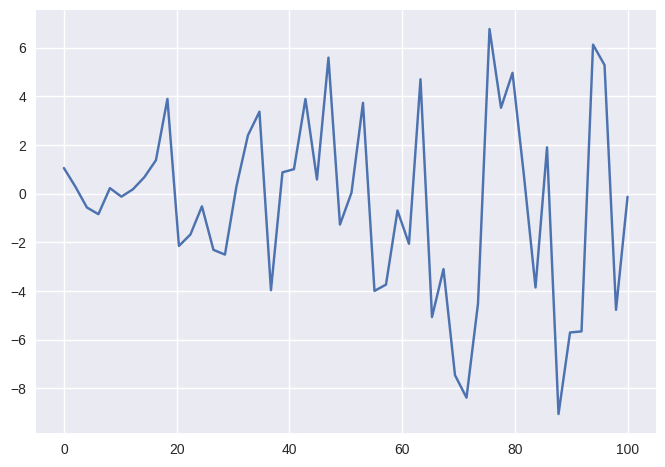

In [3]:
fig, ax = plt.subplots()
plt.plot(x, y)

In [4]:
class Model(nn.Module):
    
    def __init__(self, init_callback=None):
        super().__init__()
        self.weights = nn.Parameter(torch.Tensor(10, ))
        with torch.no_grad():
            # torch.manual_seed(5)
            # self.weights.data.uniform_(-0.1, 0.1)
            if init_callback is not None and callable(init_callback):
                init_callback(self.weights)
            else:
                nn.init.uniform_(self.weights.data, -0.1, 0.1)
        print(self.weights)
        print()
    
    def forward(self, x):
        out = x @ self.weights
        return out

In [5]:
def train(model, x, y, epochs, batch_size, optimizer, scheduler=None):
    loss_fn = nn.MSELoss()
    total_size = x.size(0)
    losses = []
    lr = []
    if scheduler is not None:
        lr.append(scheduler.get_lr()[0])
    for i in range(epochs):
        for j in range(total_size // batch_size):
            batch_x = x[j*batch_size:(j+1)*batch_size]
            batch_y = y[j*batch_size:(j+1)*batch_size]
            out = model(batch_x)
            # print(out, batch_y, (out-batch_y).pow(2).mean())
            loss = loss_fn(out, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    
        if scheduler is not None:
            scheduler.step()
            lr.append(scheduler.get_last_lr()[0])
            # print(f"Epoch: {i}/{epochs}, Batch: {j}/{total_size}, Loss:{loss.item()}")
        print(f"Epoch: {i}/{epochs},  Loss:{loss.item()}")
    
    return {'loss': losses, 'lr': lr}

In [6]:
torch.manual_seed(0)
x = torch.linspace(0, 100, 600)
# x = (x - x.mean()) / (x.std())
perm = torch.randperm(x.size(0))
x = x[perm]
x = x.view(60, 10)
w = torch.empty(10).uniform_(-0.1, 0.1) 
epsilon = 0.5 * torch.randn(60)
y = x @ w + epsilon
x, x_test = x[:50], x[50:]
y, y_test = y[:50], y[50:]
y.shape, y

(torch.Size([50]),
 tensor([-19.3272, -11.2376, -10.6880,  -4.8661,  -8.2158,  -1.2466,  -6.6260,
         -18.8222,  -5.2430,  -7.4391,  -0.9972,  -9.6385,   0.0504, -11.0449,
          -9.3575, -19.2389,  -0.3441,   3.0253,  -5.0637,  -8.1677,  -3.8418,
         -18.2966, -10.9858,  -8.5272,  -8.5089,  -4.7166,  -9.9437,   3.0276,
          -0.1267, -13.8013,  -8.3309,  -9.6444,  -0.2801,  -9.0618,  -7.6405,
         -12.7412, -17.6529,  -2.1812,  -7.4456,  -0.7018,  -5.9153,  -9.6925,
         -12.1453,   0.3231,  -9.3671,  -1.9607,  -3.2736,   7.3688,  -1.9351,
          -9.8541]))

In [7]:
x@w + epsilon[:50] - y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

Parameter containing:
tensor([ 0.0684, -0.0159, -0.0828,  0.0495,  0.0299,  0.0402, -0.0617,  0.0644,
         0.0947,  0.0087], requires_grad=True)

Epoch: 0/20,  Loss:60.01715087890625
Epoch: 1/20,  Loss:104.19743347167969
Epoch: 2/20,  Loss:34.695167541503906
Epoch: 3/20,  Loss:39.91773986816406
Epoch: 4/20,  Loss:18.75936508178711
Epoch: 5/20,  Loss:19.95583724975586
Epoch: 6/20,  Loss:8.695570945739746
Epoch: 7/20,  Loss:8.303361892700195
Epoch: 8/20,  Loss:3.59721040725708
Epoch: 9/20,  Loss:2.695509672164917
Epoch: 10/20,  Loss:1.6240947246551514
Epoch: 11/20,  Loss:1.5387235879898071
Epoch: 12/20,  Loss:0.6178070306777954
Epoch: 13/20,  Loss:0.4315585196018219
Epoch: 14/20,  Loss:0.5302214622497559
Epoch: 15/20,  Loss:0.27356579899787903
Epoch: 16/20,  Loss:0.19831882417201996
Epoch: 17/20,  Loss:0.22793284058570862
Epoch: 18/20,  Loss:0.19733288884162903
Epoch: 19/20,  Loss:0.18341714143753052


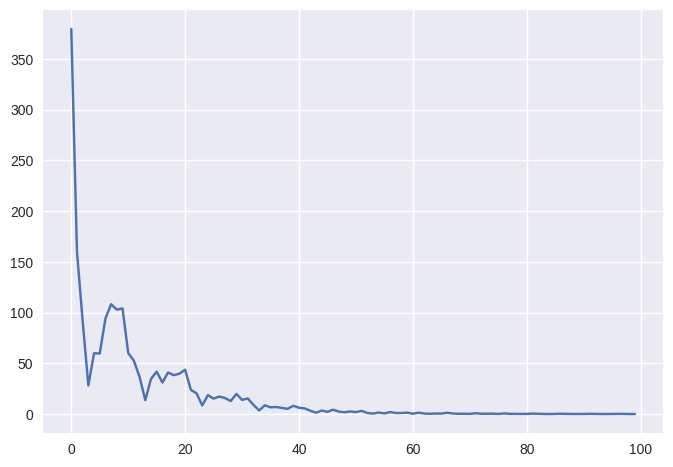

In [8]:
model = Model()
adam_optimizer = opt.Adam(model.parameters(), lr=1e-2,)

adam_train = train(model, x, y, 20, batch_size=10, optimizer=adam_optimizer)
fig, ax = plt.subplots()
ax.plot(adam_train['loss'])

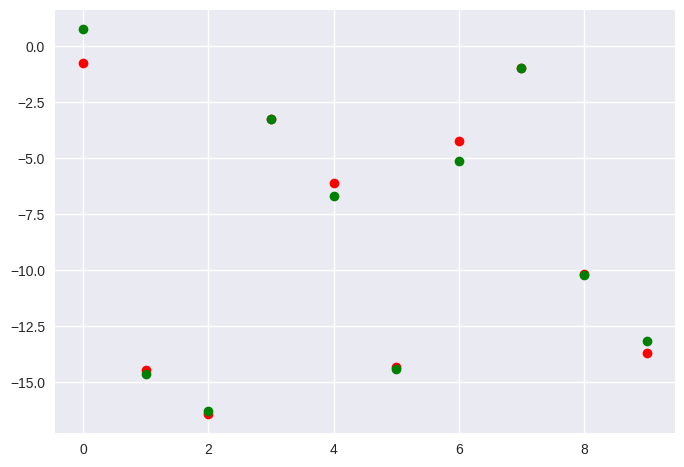

In [9]:
with torch.no_grad():
    preds = model(x_test)
    fig, ax = plt.subplots()
    ax.plot(y_test, 'ro')
    ax.plot(preds.detach(),  'go')
    
            

In [10]:
model.weights

Parameter containing:
tensor([ 0.0882, -0.0849, -0.0349, -0.0676,  0.0917, -0.0467, -0.0479,  0.0555,
        -0.0462, -0.0456], requires_grad=True)

In [11]:
w

tensor([ 0.0903, -0.0844, -0.0377, -0.0688,  0.0947, -0.0430, -0.0457,  0.0524,
        -0.0463, -0.0493])

In [12]:
preds

tensor([  0.7575, -14.6330, -16.3181,  -3.2614,  -6.6866, -14.4254,  -5.1562,
         -0.9964, -10.2363, -13.1958])

In [13]:
y_test

tensor([ -0.7472, -14.4743, -16.4365,  -3.2386,  -6.0997, -14.3555,  -4.2477,
         -0.9996, -10.1680, -13.6955])

In [14]:
for group in adam_optimizer.param_groups:
    print(group)

{'params': [Parameter containing:
tensor([ 0.0882, -0.0849, -0.0349, -0.0676,  0.0917, -0.0467, -0.0479,  0.0555,
        -0.0462, -0.0456], requires_grad=True)], 'lr': 0.01, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None}


Initializing with SGD
Parameter containing:
tensor([-0.9340,  0.7020, -0.7415,  0.2299,  0.1453, -0.4680,  0.3482, -0.8944,
         0.2278, -0.6340], requires_grad=True)

Epoch: 0/30,  Loss:6904.3701171875
Epoch: 1/30,  Loss:1413.3814697265625
Epoch: 2/30,  Loss:244.6115264892578
Epoch: 3/30,  Loss:805.0931396484375
Epoch: 4/30,  Loss:882.0172729492188
Epoch: 5/30,  Loss:331.74371337890625
Epoch: 6/30,  Loss:35.7805290222168
Epoch: 7/30,  Loss:80.55355072021484
Epoch: 8/30,  Loss:105.17277526855469
Epoch: 9/30,  Loss:75.09736633300781
Epoch: 10/30,  Loss:8.81478214263916
Epoch: 11/30,  Loss:3.622938632965088
Epoch: 12/30,  Loss:8.66445541381836
Epoch: 13/30,  Loss:12.435323715209961
Epoch: 14/30,  Loss:2.216318130493164
Epoch: 15/30,  Loss:0.6141872406005859
Epoch: 16/30,  Loss:0.7861403226852417
Epoch: 17/30,  Loss:1.3118200302124023
Epoch: 18/30,  Loss:0.7392412424087524
Epoch: 19/30,  Loss:0.36876028776168823
Epoch: 20/30,  Loss:0.21707351505756378
Epoch: 21/30,  Loss:0.32038331031

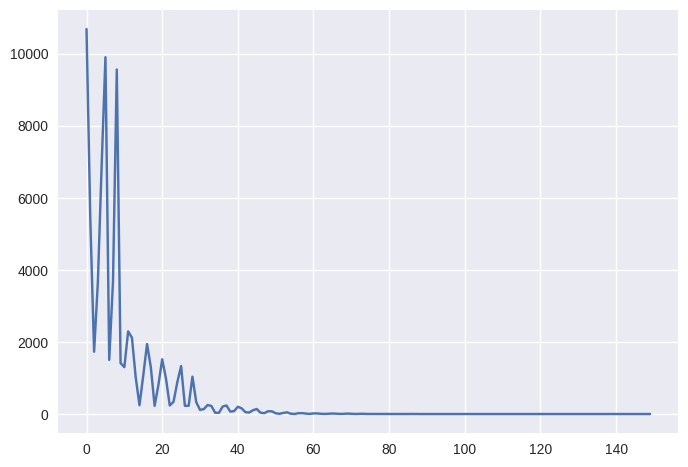

In [15]:
@torch.no_grad()
def init_sgd(model_weights):
    print("Initializing with SGD")
    model_weights.data.uniform_(-1, 1)
model = Model(init_sgd)
sgd_optimizer = opt.SGD(model.parameters(), lr=1e-5, momentum=0.9)

sgd_train = train(model, x, y, 30, batch_size=10, optimizer=sgd_optimizer)
fig, ax = plt.subplots()
ax.plot(sgd_train['loss'])

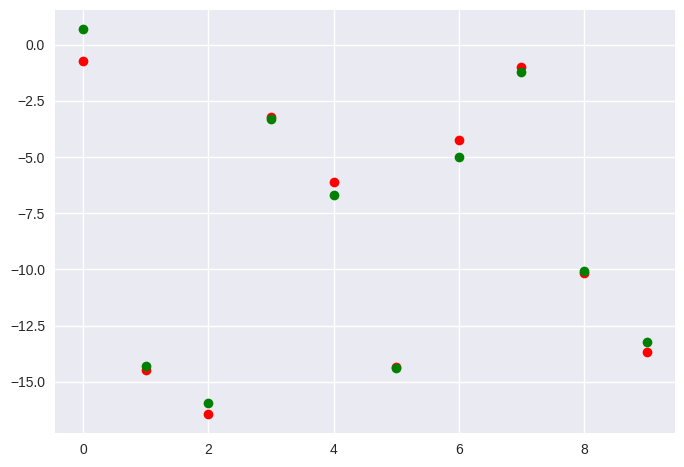

In [16]:
with torch.no_grad():
    preds = model(x_test)
    fig, ax = plt.subplots()
    ax.plot(y_test, 'ro')
    ax.plot(preds.detach(),  'go')

In [17]:
for group in sgd_optimizer.param_groups:
    print(group)

{'params': [Parameter containing:
tensor([ 0.0872, -0.0831, -0.0325, -0.0680,  0.0908, -0.0448, -0.0442,  0.0538,
        -0.0482, -0.0471], requires_grad=True)], 'lr': 1e-05, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False}


Initializing with Ada
Parameter containing:
tensor([-0.0108,  0.0129,  0.0852, -0.0477,  0.0641, -0.0127, -0.0475, -0.0871,
        -0.0918,  0.0977], requires_grad=True)

Epoch: 0/30,  Loss:59.641998291015625
Epoch: 1/30,  Loss:59.44453811645508
Epoch: 2/30,  Loss:57.199188232421875
Epoch: 3/30,  Loss:53.95623016357422
Epoch: 4/30,  Loss:50.50469207763672
Epoch: 5/30,  Loss:47.114845275878906
Epoch: 6/30,  Loss:43.86103057861328
Epoch: 7/30,  Loss:40.75971984863281
Epoch: 8/30,  Loss:37.812705993652344
Epoch: 9/30,  Loss:35.01852798461914
Epoch: 10/30,  Loss:32.3748893737793
Epoch: 11/30,  Loss:29.87896728515625
Epoch: 12/30,  Loss:27.52724838256836
Epoch: 13/30,  Loss:25.315486907958984
Epoch: 14/30,  Loss:23.238704681396484
Epoch: 15/30,  Loss:21.29124641418457
Epoch: 16/30,  Loss:19.466888427734375
Epoch: 17/30,  Loss:17.758981704711914
Epoch: 18/30,  Loss:16.160633087158203
Epoch: 19/30,  Loss:14.664947509765625
Epoch: 20/30,  Loss:13.265317916870117
Epoch: 21/30,  Loss:11.9557132

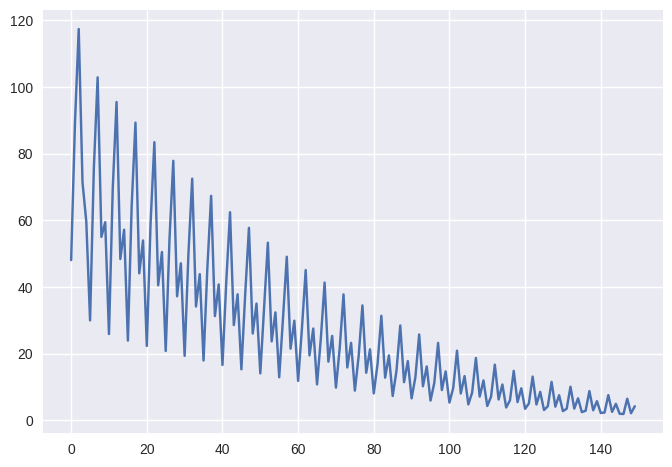

In [18]:
@torch.no_grad()
def init_ada(model_weights):
    print("Initializing with Ada")
    model_weights.data.uniform_(-0.1, 0.1)
model = Model(init_ada)
ada_optimizer = opt.Adadelta(model.parameters(), lr=5e-1)
ada_train = train(model, x, y, 30, batch_size=10, optimizer=ada_optimizer)
fig, ax = plt.subplots()
ax.plot(ada_train['loss'])

Initializing with Ada
Parameter containing:
tensor([-0.0412, -0.0640, -0.0693, -0.0161, -0.0177,  0.0445, -0.0427,  0.0797,
        -0.0702,  0.0003], requires_grad=True)

Epoch: 0/30,  Loss:58.029075622558594
Epoch: 1/30,  Loss:44.3197021484375
Epoch: 2/30,  Loss:34.488441467285156
Epoch: 3/30,  Loss:27.2021427154541
Epoch: 4/30,  Loss:21.741565704345703
Epoch: 5/30,  Loss:17.596715927124023
Epoch: 6/30,  Loss:14.409482955932617
Epoch: 7/30,  Loss:11.928457260131836
Epoch: 8/30,  Loss:9.975907325744629
Epoch: 9/30,  Loss:8.424887657165527
Epoch: 10/30,  Loss:7.183558464050293
Epoch: 11/30,  Loss:6.184564590454102
Epoch: 12/30,  Loss:5.377790927886963
Epoch: 13/30,  Loss:4.7254157066345215
Epoch: 14/30,  Loss:4.1985626220703125
Epoch: 15/30,  Loss:3.7749762535095215
Epoch: 16/30,  Loss:3.43743634223938
Epoch: 17/30,  Loss:3.172638416290283
Epoch: 18/30,  Loss:2.970364570617676
Epoch: 19/30,  Loss:2.8227787017822266
Epoch: 20/30,  Loss:2.723461389541626
Epoch: 21/30,  Loss:2.67839670181

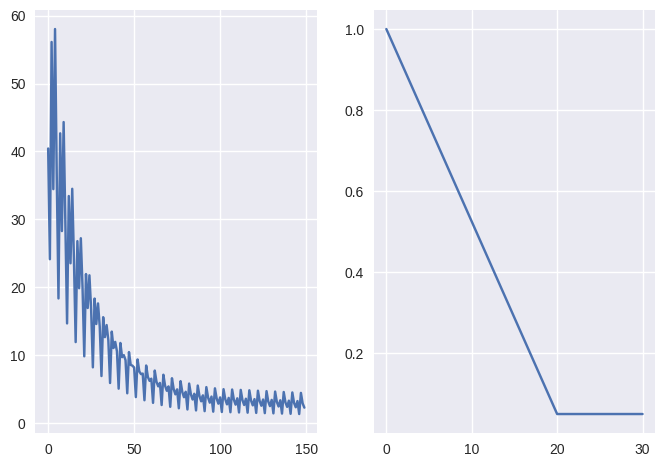

In [32]:
@torch.no_grad()
def init_ada(model_weights):
    print("Initializing with Ada")
    model_weights.data.uniform_(-0.1, 0.1)
model = Model(init_ada)
ada_optimizer = opt.Adadelta(model.parameters(), lr=1e-0)
step_sch = lr_scheduler.LinearLR(ada_optimizer, 1., 0.05, 20)
ada_sch_train = train(model, x, y, 30, batch_size=10, optimizer=ada_optimizer, scheduler=step_sch)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(ada_sch_train['loss'])
ax2.plot(ada_sch_train['lr'])


In [33]:
ada_sch_train['lr']

[1.0,
 0.9525,
 0.905,
 0.8575,
 0.81,
 0.7625000000000001,
 0.7150000000000001,
 0.6675000000000001,
 0.6200000000000001,
 0.5725000000000001,
 0.5250000000000001,
 0.4775000000000001,
 0.4300000000000001,
 0.3825000000000001,
 0.3350000000000001,
 0.2875000000000001,
 0.2400000000000001,
 0.1925000000000001,
 0.1450000000000001,
 0.0975000000000001,
 0.05000000000000004,
 0.05000000000000004,
 0.05000000000000004,
 0.05000000000000004,
 0.05000000000000004,
 0.05000000000000004,
 0.05000000000000004,
 0.05000000000000004,
 0.05000000000000004,
 0.05000000000000004,
 0.05000000000000004]

Initializing with Ada
Parameter containing:
tensor([-0.0427, -0.0080, -0.0438, -0.0138,  0.0217,  0.0134, -0.0189, -0.1000,
         0.0051, -0.0030], requires_grad=True)

Epoch: 0/30,  Loss:75.69671630859375
Epoch: 1/30,  Loss:58.243370056152344
Epoch: 2/30,  Loss:43.140647888183594
Epoch: 3/30,  Loss:21.99342918395996
Epoch: 4/30,  Loss:10.154391288757324
Epoch: 5/30,  Loss:4.216361045837402
Epoch: 6/30,  Loss:2.344849109649658
Epoch: 7/30,  Loss:2.1977028846740723
Epoch: 8/30,  Loss:1.172853708267212
Epoch: 9/30,  Loss:0.4849777817726135
Epoch: 10/30,  Loss:0.5609791278839111
Epoch: 11/30,  Loss:1.2946088314056396
Epoch: 12/30,  Loss:1.0748355388641357
Epoch: 13/30,  Loss:1.0552785396575928
Epoch: 14/30,  Loss:0.6757093667984009
Epoch: 15/30,  Loss:0.476919025182724
Epoch: 16/30,  Loss:0.3325650990009308
Epoch: 17/30,  Loss:0.33232390880584717
Epoch: 18/30,  Loss:0.46262913942337036
Epoch: 19/30,  Loss:0.45309752225875854
Epoch: 20/30,  Loss:0.5750980377197266
Epoch: 21/30,  Loss:0.

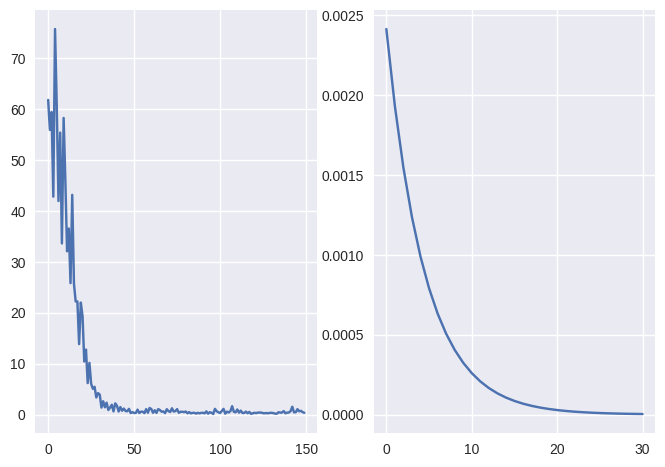

In [41]:
@torch.no_grad()
def init_ada(model_weights):
    print("Initializing with Ada")
    model_weights.data.uniform_(-0.1, 0.1)
model = Model(init_ada)
rms_optimizer = opt.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-5, alpha=0.1, momentum=0.9)
exp_sch = lr_scheduler.ExponentialLR(ada_optimizer, 0.8,)
rms_sch_train = train(model, x, y, 30, batch_size=10, optimizer=rms_optimizer, scheduler=exp_sch)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(rms_sch_train['loss'])
ax2.plot(rms_sch_train['lr'])


In [42]:
rms_sch_train['lr']

[0.0024148010621743866,
 0.0019318408497395094,
 0.0015454726797916075,
 0.0012363781438332862,
 0.000989102515066629,
 0.0007912820120533033,
 0.0006330256096426426,
 0.0005064204877141142,
 0.00040513639017129133,
 0.0003241091121370331,
 0.0002592872897096265,
 0.0002074298317677012,
 0.00016594386541416098,
 0.00013275509233132878,
 0.00010620407386506303,
 8.496325909205043e-05,
 6.797060727364035e-05,
 5.437648581891228e-05,
 4.350118865512983e-05,
 3.480095092410386e-05,
 2.7840760739283092e-05,
 2.2272608591426474e-05,
 1.781808687314118e-05,
 1.4254469498512944e-05,
 1.1403575598810356e-05,
 9.122860479048285e-06,
 7.298288383238629e-06,
 5.838630706590903e-06,
 4.670904565272723e-06,
 3.7367236522181787e-06,
 2.9893789217745432e-06]

In [43]:
np.array(rms_sch_train['lr'][1:]) / np.array(rms_sch_train['lr'])[:-1]

array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
       0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
       0.8, 0.8, 0.8, 0.8])

Initializing with Ada
Parameter containing:
tensor([ 0.0461, -0.0886, -0.0063,  0.0334,  0.0300,  0.0837,  0.0983,  0.0910,
         0.0671,  0.0703], requires_grad=True)

Epoch: 0/30,  Loss:536.784423828125
Epoch: 1/30,  Loss:152.70309448242188
Epoch: 2/30,  Loss:89.77626037597656
Epoch: 3/30,  Loss:130.1422882080078
Epoch: 4/30,  Loss:55.44646453857422
Epoch: 5/30,  Loss:54.30842208862305
Epoch: 6/30,  Loss:44.55265426635742
Epoch: 7/30,  Loss:31.333465576171875
Epoch: 8/30,  Loss:20.733871459960938
Epoch: 9/30,  Loss:11.607739448547363
Epoch: 10/30,  Loss:4.678389072418213
Epoch: 11/30,  Loss:1.6334279775619507
Epoch: 12/30,  Loss:0.7244747281074524
Epoch: 13/30,  Loss:0.7795714139938354
Epoch: 14/30,  Loss:1.3854179382324219
Epoch: 15/30,  Loss:1.0787780284881592
Epoch: 16/30,  Loss:0.8682622909545898
Epoch: 17/30,  Loss:0.655960202217102
Epoch: 18/30,  Loss:0.5449727773666382
Epoch: 19/30,  Loss:0.5180463790893555
Epoch: 20/30,  Loss:0.7084180116653442
Epoch: 21/30,  Loss:0.263025

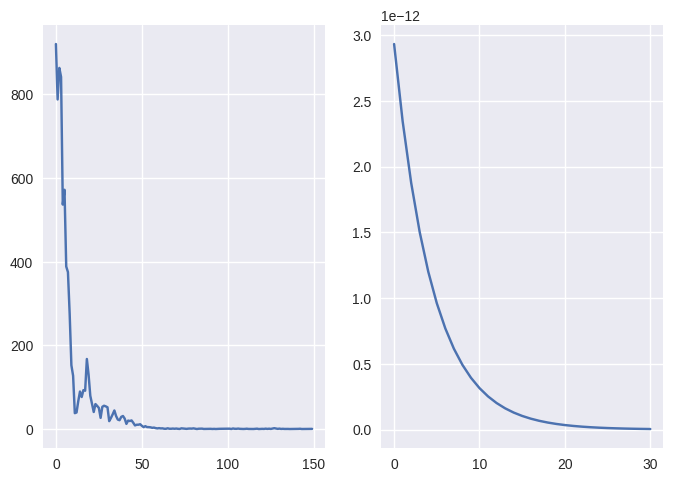

In [48]:
@torch.no_grad()
def init_ada(model_weights):
    print("Initializing with Ada")
    model_weights.data.uniform_(-0.1, 0.1)
model = Model(init_ada)
rms_optimizer = opt.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-5, alpha=0.1, momentum=0.9)
exp_sch = lr_scheduler.ExponentialLR(ada_optimizer, 0.8, )
rms_sch_train = train(model, x, y, 30, batch_size=10, optimizer=rms_optimizer, scheduler=exp_sch)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(rms_sch_train['loss'])
ax2.plot(rms_sch_train['lr'])

In [47]:
rms_sch_train['lr']

[1.894743992248562e-09,
 1.894743992248562e-09,
 1.5157951937988497e-09,
 1.2126361550390797e-09,
 9.70108924031264e-10,
 7.760871392250112e-10,
 6.20869711380009e-10,
 4.966957691040072e-10,
 3.973566152832058e-10,
 3.1788529222656464e-10,
 2.543082337812517e-10,
 2.0344658702500136e-10,
 1.627572696200011e-10,
 1.3020581569600089e-10,
 1.0416465255680071e-10,
 8.333172204544057e-11,
 6.666537763635246e-11,
 5.333230210908197e-11,
 4.266584168726558e-11,
 3.4132673349812466e-11,
 2.7306138679849975e-11,
 2.184491094387998e-11,
 1.7475928755103987e-11,
 1.398074300408319e-11,
 1.1184594403266552e-11,
 8.947675522613242e-12,
 7.158140418090594e-12,
 5.7265123344724755e-12,
 4.5812098675779805e-12,
 3.664967894062385e-12,
 2.931974315249908e-12]

In [49]:
exp_sch.state_dict()

{'gamma': 0.8,
 'base_lrs': [1.0],
 'last_epoch': 30,
 'verbose': False,
 '_step_count': 31,
 '_get_lr_called_within_step': False,
 '_last_lr': [3.629608399004204e-15]}

In [50]:
step_sch.state_dict()

{'start_factor': 1.0,
 'end_factor': 0.05,
 'total_iters': 20,
 'base_lrs': [1.0],
 'last_epoch': 30,
 'verbose': False,
 '_step_count': 31,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.05000000000000004]}

In [51]:
adam_optimizer.state

defaultdict(dict,
            {Parameter containing:
             tensor([ 0.0882, -0.0849, -0.0349, -0.0676,  0.0917, -0.0467, -0.0479,  0.0555,
                     -0.0462, -0.0456], requires_grad=True): {'step': tensor(100.),
              'exp_avg': tensor([ 3.0510, -3.2957, -1.8470, -2.1473,  1.6491, -2.6560, -6.4458,  3.3393,
                       5.8945,  0.9475]),
              'exp_avg_sq': tensor([ 9667.7197, 13671.1416,  7913.3745,  9617.9150,  9702.7734, 11329.8594,
                      13688.7471, 11209.8389, 10519.1807,  9975.8848])}})